# Model

In [551]:
%config InlineBackend.figure_format = 'retina'

from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import groupby
from math import sqrt

### Calculate mode of the data

In [552]:
def getMode(x):
    frequency = groupby(Counter(x).most_common(), lambda x:x[1])
    mode = [val for val,count in frequency.next()[1]]
    return mode

## Distance measure

In [553]:
class DistanceMeasure:
    @staticmethod
    def EuclidianDistance(a, b):
        return np.sqrt(np.sum((a - b)**2))

## Feature scaling
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/b0aa2e7d203db1526c577192f2d9102b718eafd5">

In [554]:
def scaleFeature(x):
    mean = np.mean(x)
    stdDeviation = np.std(x)
    return x.apply(lambda y: ((y * 1.0) - mean)/(stdDeviation))

## InvSortedLinkedList

In [555]:
"""Node has been designed for storing targetValue and distance"""
class Node:
    data = None
    payload = None
    nextNode = None
        
class InvSortedLinkedList:
    head = None
    tail = None
    
    def insert(self, node):
        """First insertion"""
        if self.head == None:
            self.head = node
            self.tail = node
        else:
            """Next insertions"""
            
            """Insertion at head"""
            if node.data > self.head.data:
                node.nextNode = self.head
                self.head = node
                
            elif node.data < self.tail.data:
                """Insertion at tail"""
                self.tail.nextNode = node
                self.tail = node
                
            else:
                """Insert at any other position"""
                ptr = self.head
                while ptr.nextNode.data > node.data:
                    ptr = ptr.nextNode
            
                node.nextNode = ptr.nextNode
                ptr.nextNode = node
    
    def removeHead(self):
        self.head = self.head.nextNode
        """Garbage collector will remove the node without any references"""

## Nearest Neighbour

In [556]:
class NearestNeighbour:
    
    __dataX = None
    __dataY = None
    __distanceMeasure = None
    
    def __init__(self, x, y, distanceMeasure):
        self.__dataX = x
        self.__dataY = y
        self.__distanceMeasure = distanceMeasure
            
    def getTopKTargets(self, x, k):
        distance = np.apply_along_axis(self.__distanceMeasure, 1, self.__dataX, x)
        
        """Implementing algorithm for finding top k closest nodes. Here instead of storing distance
        I am storing the tuple of distance and target. So no back tracing from distance to target is required
        Furthermore I am using linked list of size K.
        Worst case senerio the insertion will be order of K but removal will be order of 1. So no need to shift the
        values in the list and furthermore no need to keep on sorting it again and again with each insertion.
        The list will be pre sorted. This will further optimize the process of finding the K candidates."""
        
        """Step-1 initialize the linked list with tuple and keep it sorted in descending 
        order this process in in O(K^^2)"""
        invList = InvSortedLinkedList()
        for i in range(0, k):
            n = Node()
            n.data = distance[i]
            n.payload = self.__dataY[i]
            invList.insert(n)
            
        """Step-2 check if any candidate distance is less than largest distance(head)"""
        for i in range(k+1, len(distance)):
            if distance[i] < invList.head.data:
                n = Node()
                n.data = distance[i]
                n.payload = self.__dataY[i]
                
                """Add the candidate O(k)"""
                invList.insert(n)
                
                """Remove the largest distance(head) from list O(1)"""
                invList.removeHead()
        
        ptr = invList.head
        kTargets = []
        kDistance = []
        while ptr != None:
            kDistance.append(ptr.data)
            kTargets.append(ptr.payload)
            ptr = ptr.nextNode
        
        """Sort the targets from best to worst"""
        kTargets = kTargets[::-1]
        kDistance = kDistance[::-1]
        return kTargets, kDistance

## KNearestClassifier

In [557]:
class KNearestClassifier(NearestNeighbour):
     
    def predict(self, x, k): 
        candidates, candidateDistance = self.getTopKTargets(x, k)
        mode = getMode(candidates)
        
        if len(mode) == 1:
            return mode[0]
        else:
            """Ties found in the prediction. To solve this we will 
            remove least closest element and check for ties"""
            while(True):
                candidates = candidates[:-1]
                mode = getMode(candidates)
                
                """Check if ties are broken"""
                if len(mode) == 1:
                    return mode[0]
            

## KNearestRegressor

In [558]:
class KNearestRegressor(NearestNeighbour):
     
    def predict(self, x, k): 
        candidates, candidateDistance = self.getTopKTargets(x, k)
        return np.mean(candidates)
            

## misclassificationRate

In [559]:
def misclassificationRate(yTrue, yPrediction):
    diff = yTrue - yPrediction
    diff[diff != 0] = 1
    
    return (1.0/len(diff))*np.sum(diff)

### RMSE procedure
Will calculate root mean squared error for given Ytrue values and YPrediction.
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/fc187c3557d633423444d4c80a4a50cd6ecc3dd4">


In [560]:
"""Model accuracy estimator RMSE"""

def RMSE(yTrue, yPrediction):
    n = yTrue.shape[0]
    return sqrt((1.0) * np.sum(np.square((yTrue - yPrediction))))/n

## Split data

In [561]:
"""Splits the provided pandas dataframe into training and test dataset"""
def splitDataSet(inputDataframe, trainSetSize):
    
        trainSet = inputDataframe.sample(frac = trainSetSize)
        testSet = inputDataframe.drop(trainSet.index)
        trainSet.reindex()
        testSet.reindex()
        return trainSet, testSet

### TextEncoder

Here the data is mix of numbers and text. Text value cannot be directly used and should be converted to numeric data.<br>
For this I have created a function text encoder which accepts a pandas series. Text encoder returns a lookUp dictionary for recreating the numeric value for text value and encoded text vector.
For encoding I have applied a lambda function that will return value from dictionary.

In [562]:
""" Converts the text features into numeric values so that they can be used by 
the downstream algorithms. 
Accepts pandas series and returns lookup dictionary and encoded vector"""

def textEncoder(textVector):
    if type(textVector) == pd.core.series.Series:
        
        lookUpDictionary = {}
        lookupValue = 0
        for key in textVector.unique():
            lookUpDictionary[key] = lookupValue
            lookupValue +=1
        
        textVector = textVector.apply(lambda a: lookUpDictionary[a])
        return lookUpDictionary,textVector
            
        
    else:
        raise TypeError("Expected a pandas series as an input")   

### KFold analysis

In [563]:
def kFoldAnalysis(xTrain, yTrain, model, modelParameters, nFolds, metric, gridParameters):
    
    indices = np.array(range(0, len(xTrain)))
    folds = np.array_split(indices, nFolds)
    
    analysisMetricList = []

    
    for i in range(0, len(folds)):
        validationSet = folds[i]

        """Set difference"""
        trainSet = np.setdiff1d(indices, validationSet)
        
        modelParameters['x'] = np.take(xTrain, trainSet, axis = 0)
        modelParameters['y'] = np.take(yTrain, trainSet, axis = 0)
        
        validationX = np.take(xTrain, validationSet, axis = 0)
        validationY = np.take(yTrain, validationSet, axis = 0)
        
        mld = model(**modelParameters)
        
        prediction = []
        for xVal in validationX: 
            gridParameters['x'] = xVal
            prediction.append(mld.predict(**gridParameters))
        
        analysisMetricList.append(metric(validationY, prediction))
        
    return analysisMetricList

## KNN for classification

### Iris dataset

In [564]:
%%javascript
<!-- Ignore this block -->
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

### Load data

In [610]:
""" File path change accordingly"""
directoryPath = "Data"

irisData = pd.read_csv(directoryPath+"/iris.data", names = ["sepalLength", 
                                                            "sepalWidth", "petalLength", "petalWidth", "target"])
irisData.head()

,sepalLength,sepalWidth,petalLength,petalWidth,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [611]:
"""Generate numeric values for target"""

targetLookupDictionary, irisData['target'] = textEncoder(irisData['target'])
irisData.head()

,sepalLength,sepalWidth,petalLength,petalWidth,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


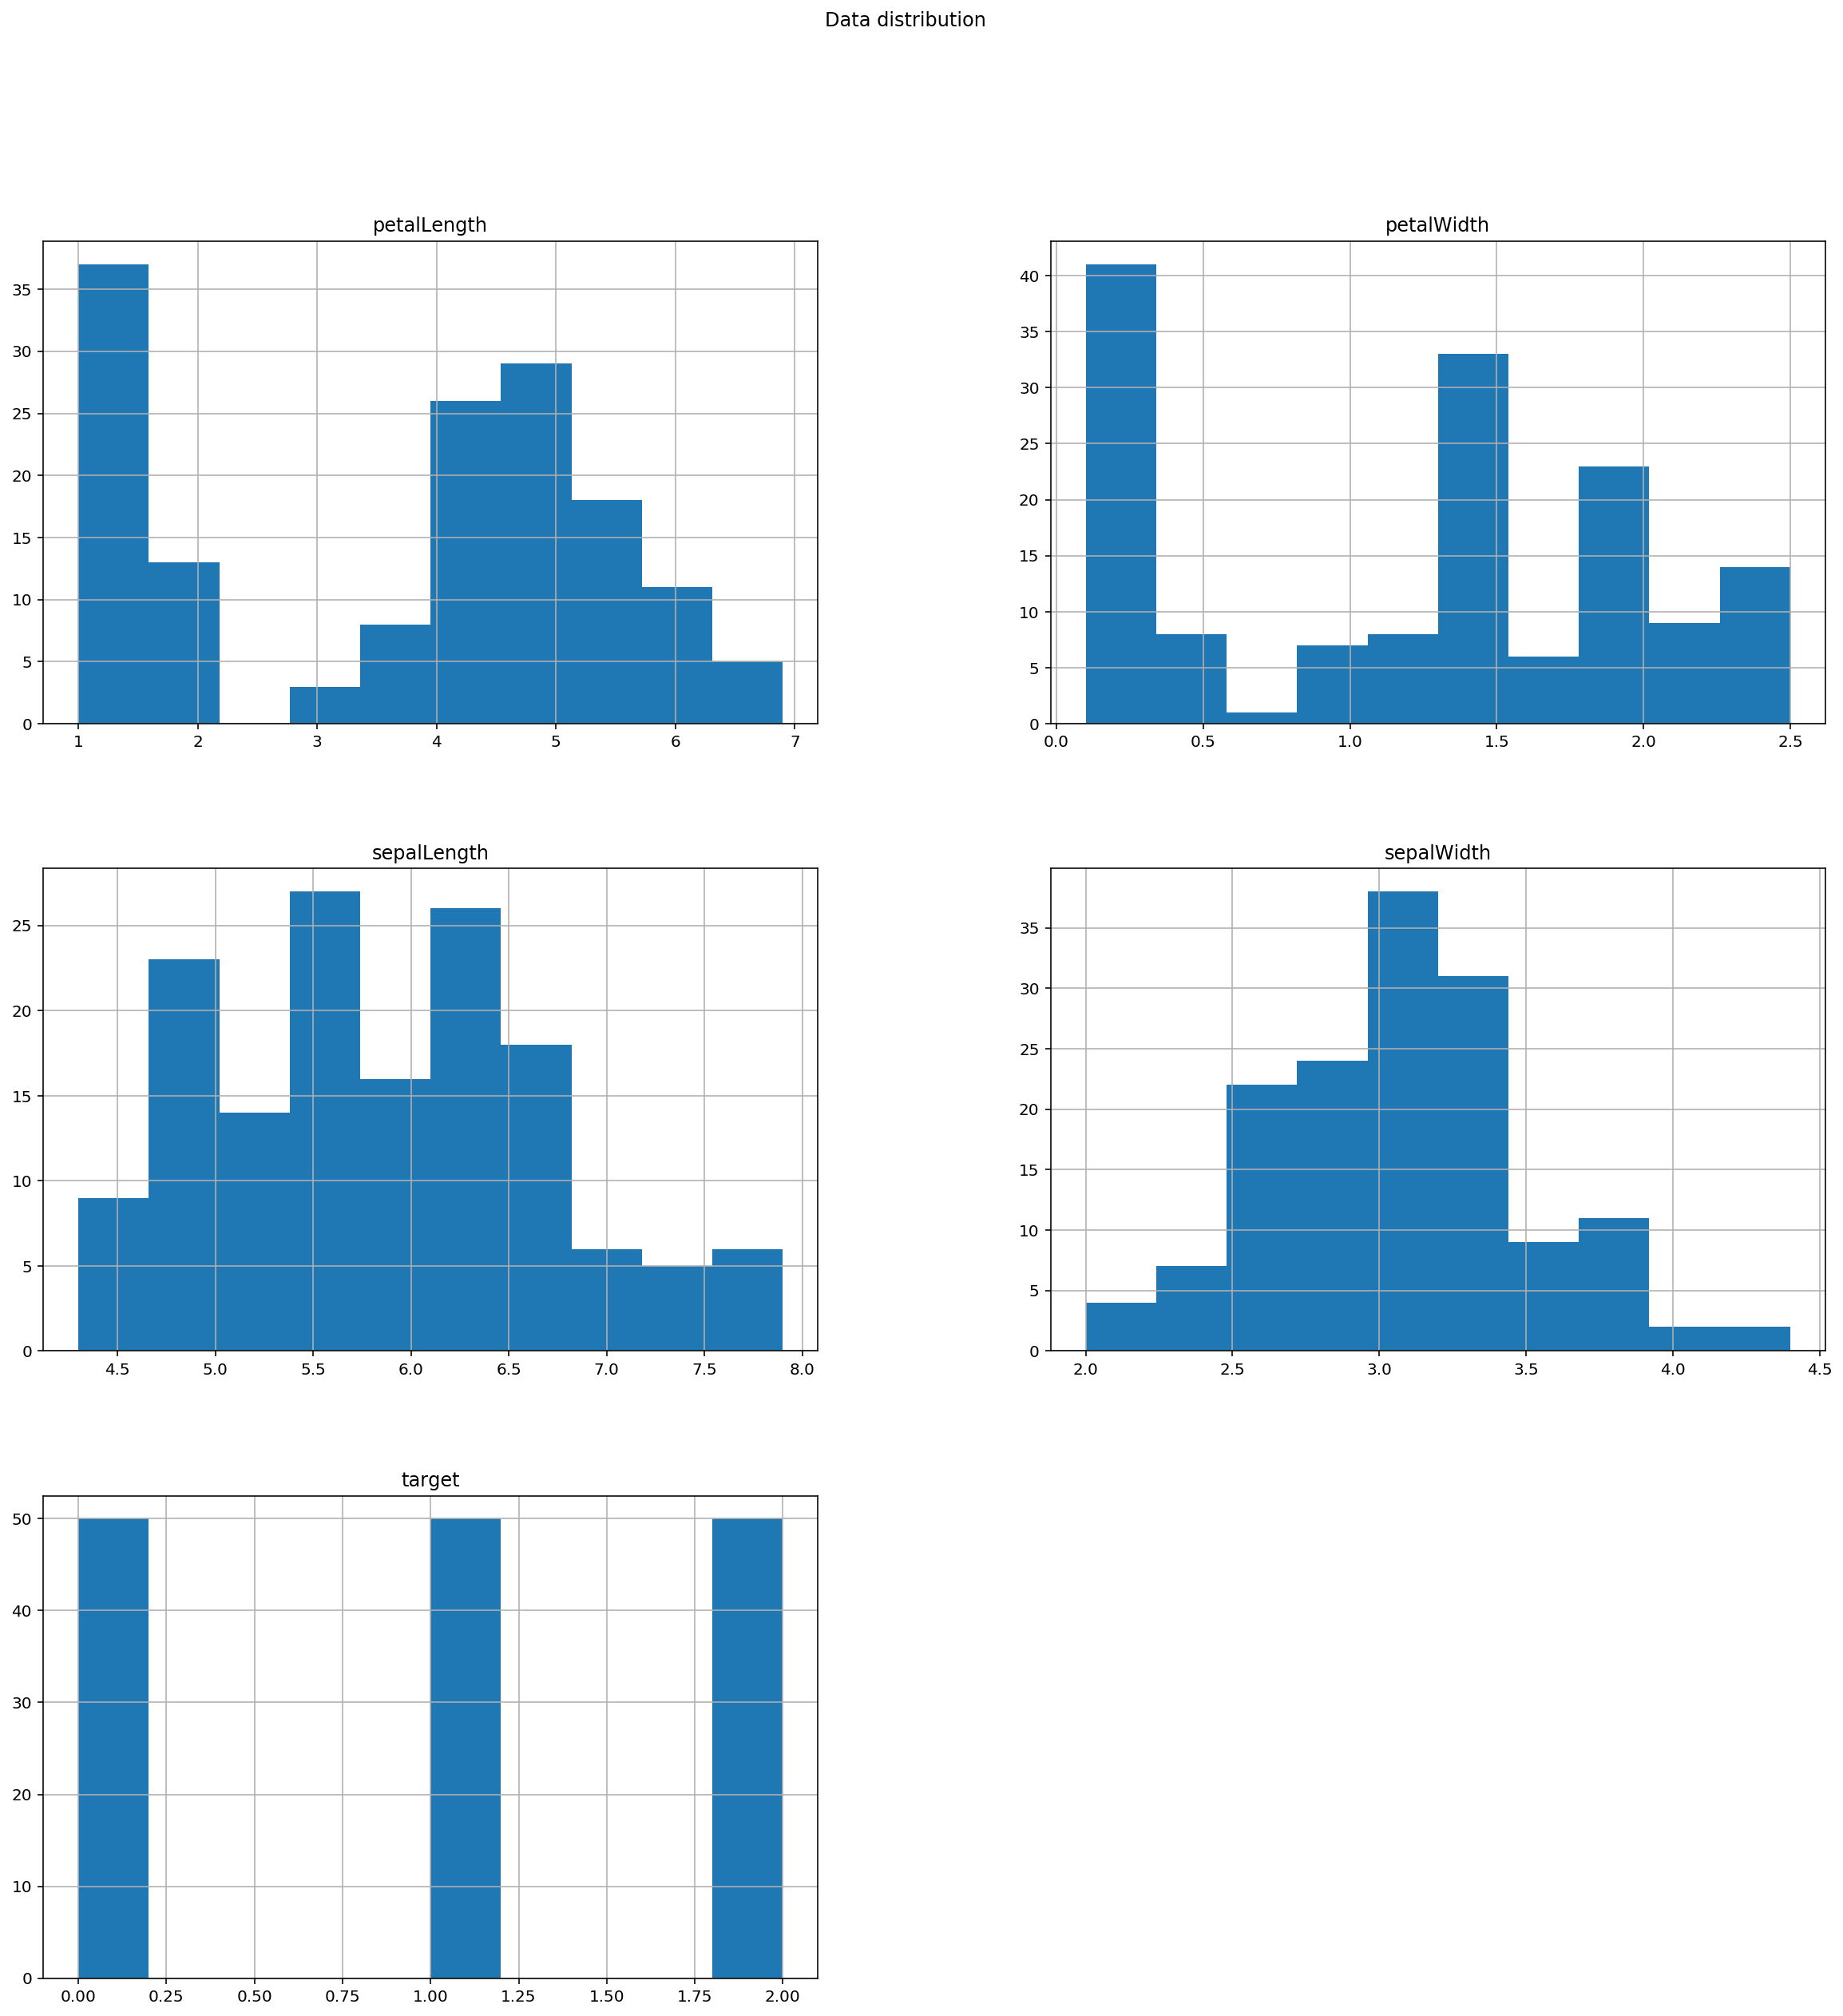

In [612]:
irisData.hist(figsize = (20, 20))
plt.suptitle("Data distribution")
plt.show()

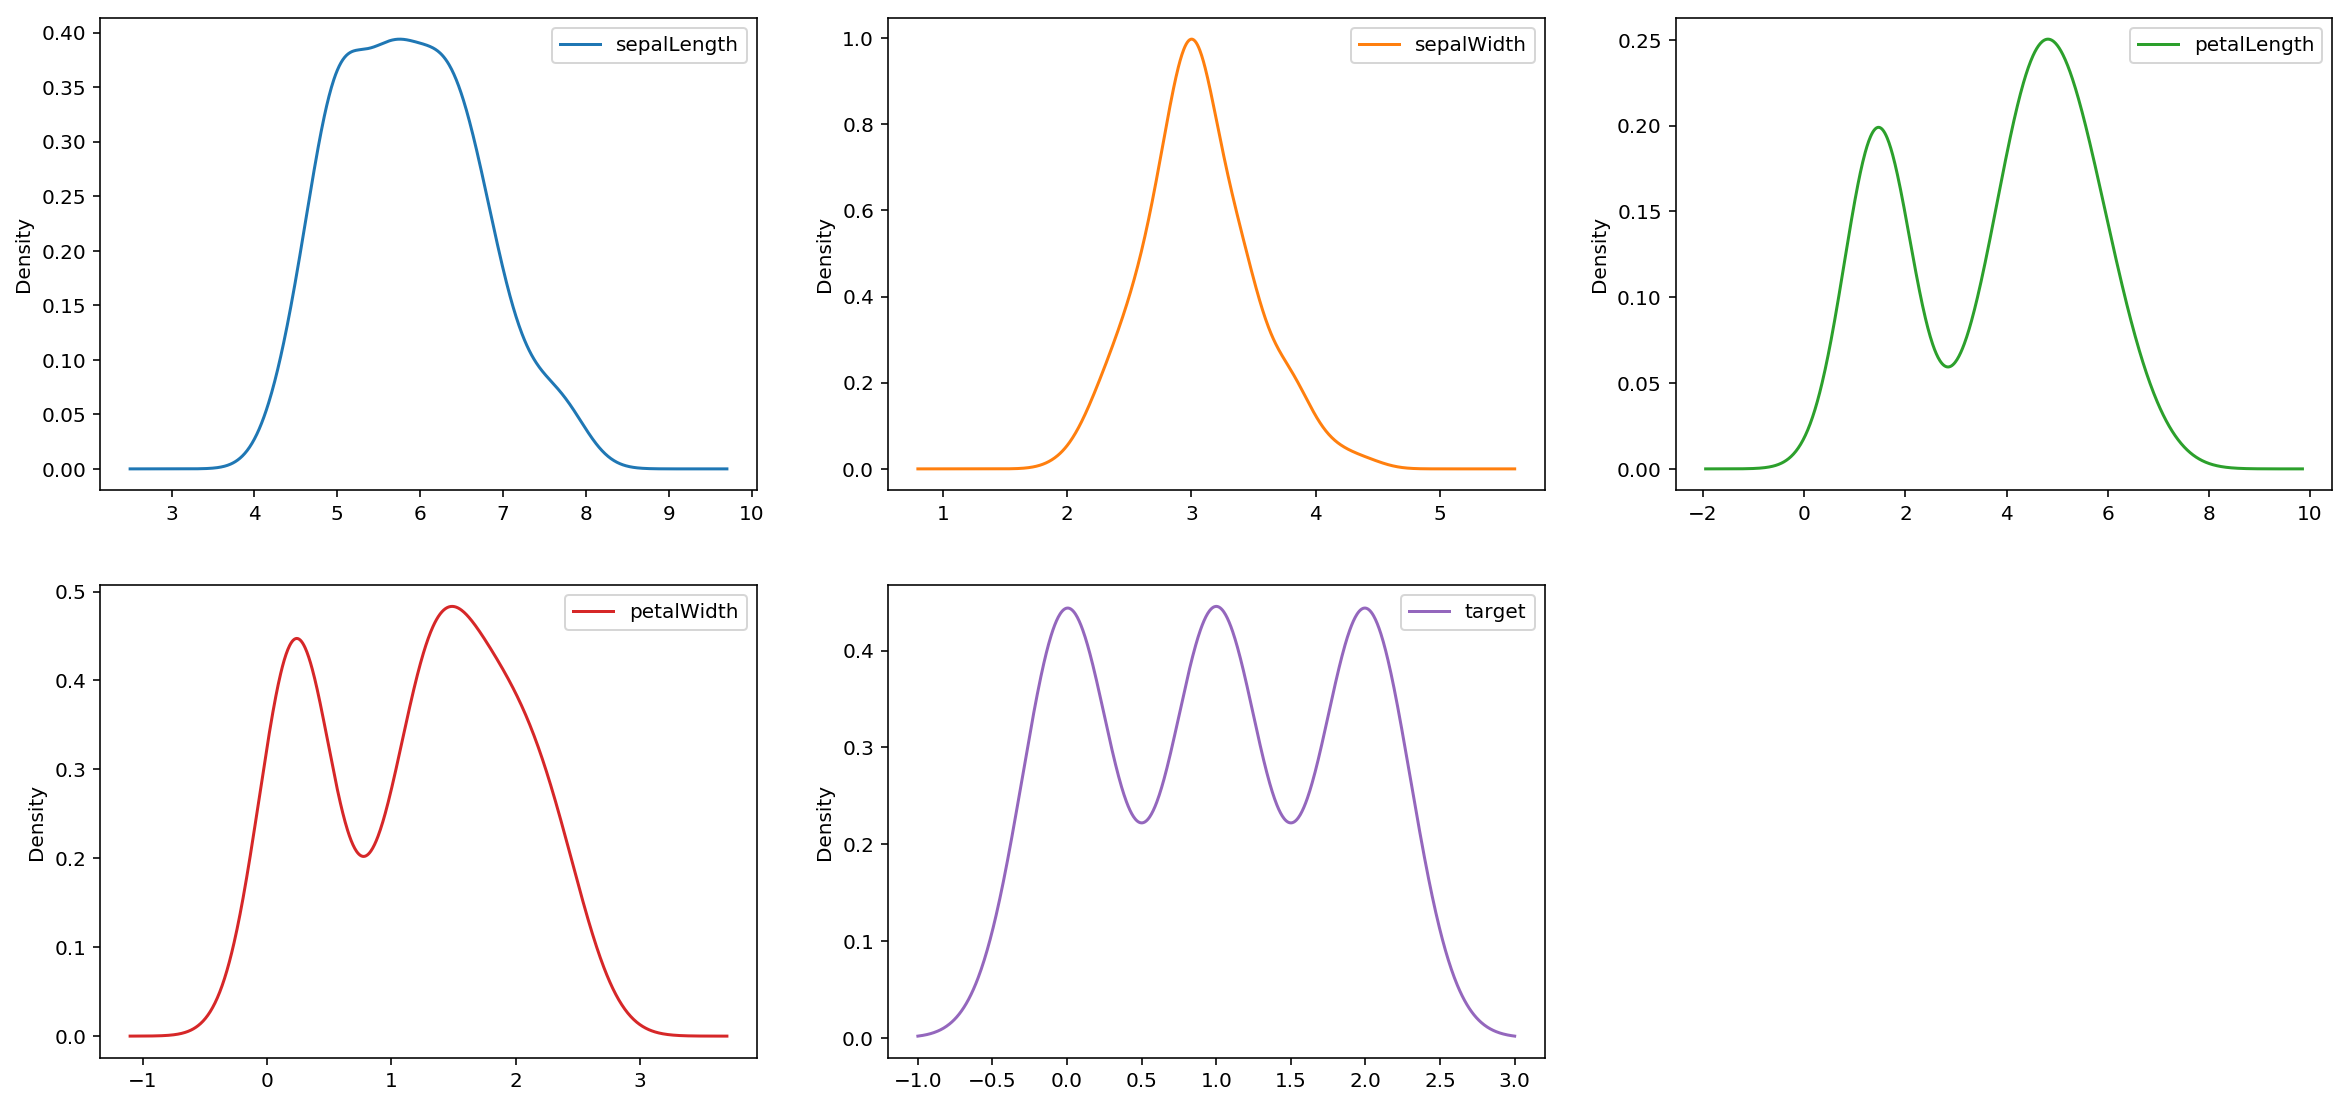

In [613]:
irisData.plot(kind='density', subplots=True, layout=(4,3), sharex=False, figsize = (20, 20))
plt.show()

In [569]:
correlation = irisData.corr(method = "spearman")
correlation

,sepalLength,sepalWidth,petalLength,petalWidth,target
sepalLength,1.000000,-0.159457,0.881386,0.834421,0.798078
sepalWidth,-0.159457,1.000000,-0.303421,-0.277511,-0.434348
petalLength,0.881386,-0.303421,1.000000,0.936003,0.935441
petalWidth,0.834421,-0.277511,0.936003,1.000000,0.937850
target,0.798078,-0.434348,0.935441,0.937850,1.000000


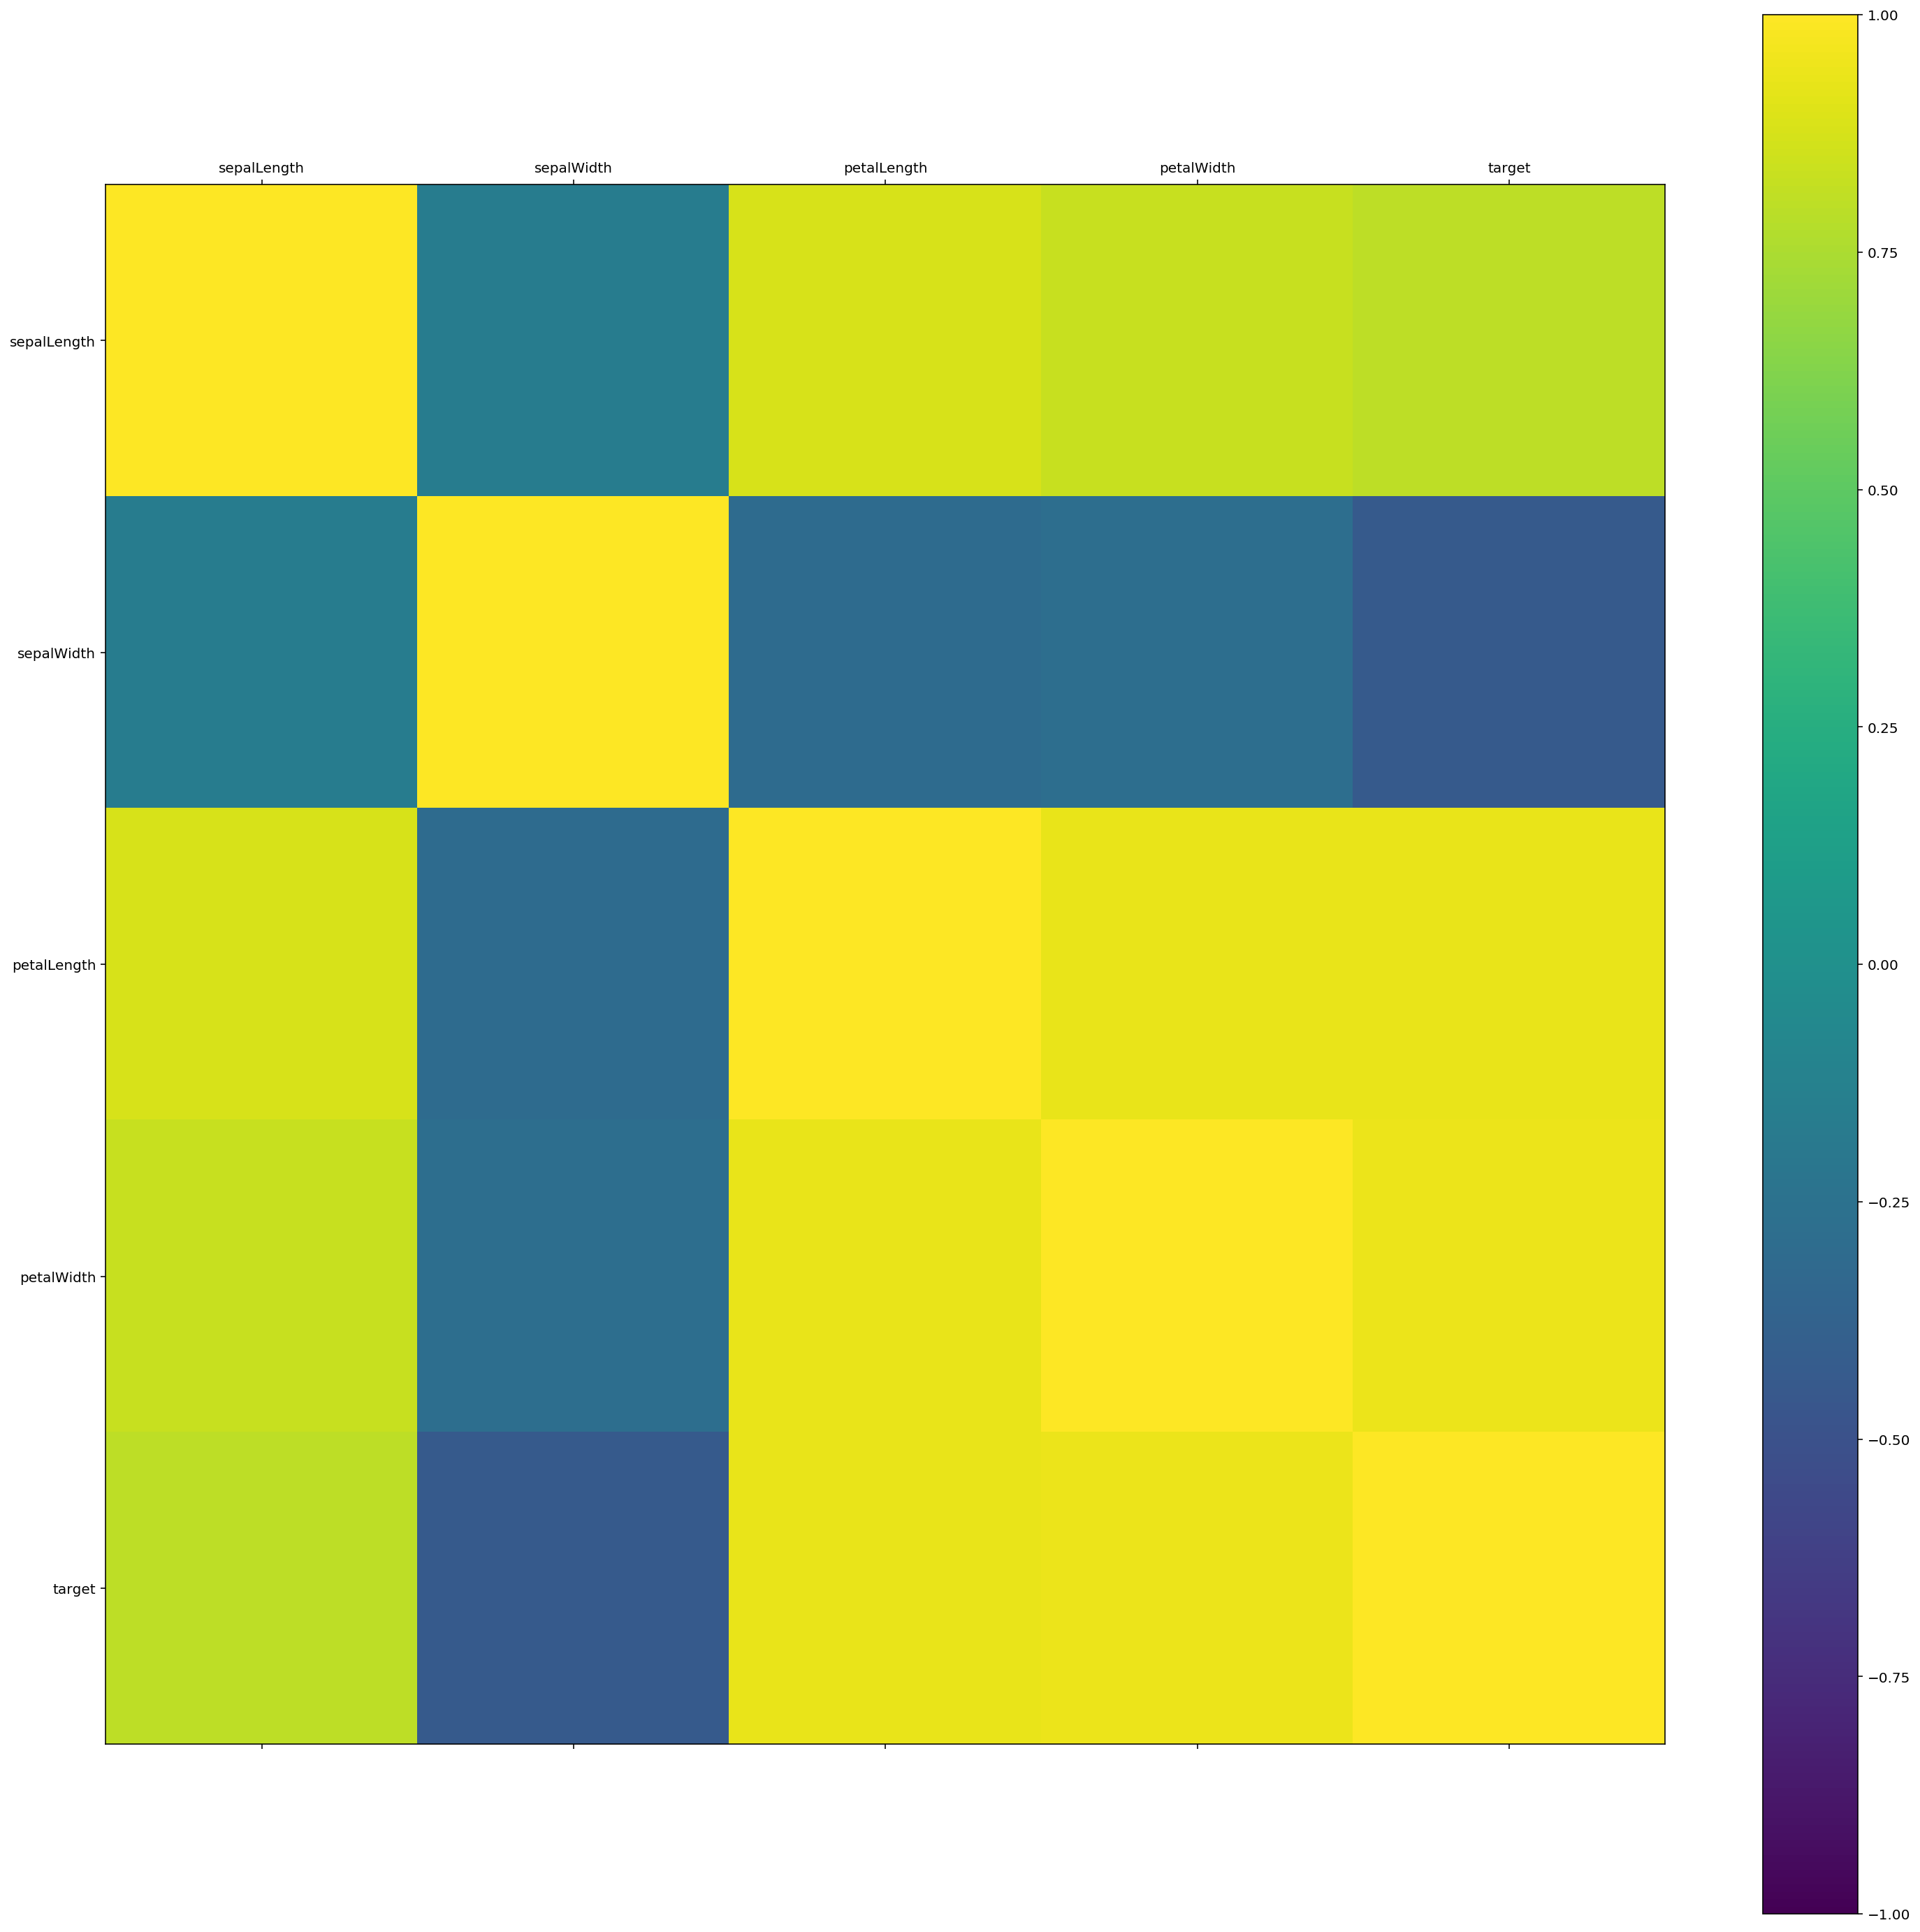

In [570]:
labels = list(irisData)
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ax.matshow(correlation)

ticks = range(0, len(labels))
cax = ax.matshow(correlation, vmin=-1, vmax=1)
fig.colorbar(cax)

ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()

### Split data

In [614]:
"""No data is dropped"""

trainSet, testSet = splitDataSet(irisData, 0.7)

xTrain = trainSet.as_matrix(columns = ["sepalLength","sepalWidth", "petalLength", "petalWidth"])
xTest = testSet.as_matrix(columns = ["sepalLength","sepalWidth", "petalLength", "petalWidth"])

yTrain = trainSet["target"].as_matrix()
yTest = testSet["target"].as_matrix()

print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)

(105, 4)
(45, 4)
(105,)
(45,)


### Train model

In [615]:
classifier = KNearestClassifier(xTrain, yTrain, DistanceMeasure.EuclidianDistance)

### Predict the values

In [616]:
yPrediction = []
k = 15

for x in xTest:
    yPrediction.append(classifier.predict(x, k))

### Calculate misclassification rate

In [617]:
print ("Misclassification is " + str(misclassificationRate(yTest, yPrediction)))

Misclassification is 0.0222222222222


### Using wine data set

### Load data

In [575]:
""" File path change accordingly"""
directoryPath = "Data"

wineData = pd.read_csv(directoryPath+"/winequality-red.csv", sep=";")
wineData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [576]:
wineData.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free sulfur dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total sulfur dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [577]:
for feature in wineData:
    if feature != "quality":
        wineData[feature] = scaleFeature(wineData[feature])

### Visualize data

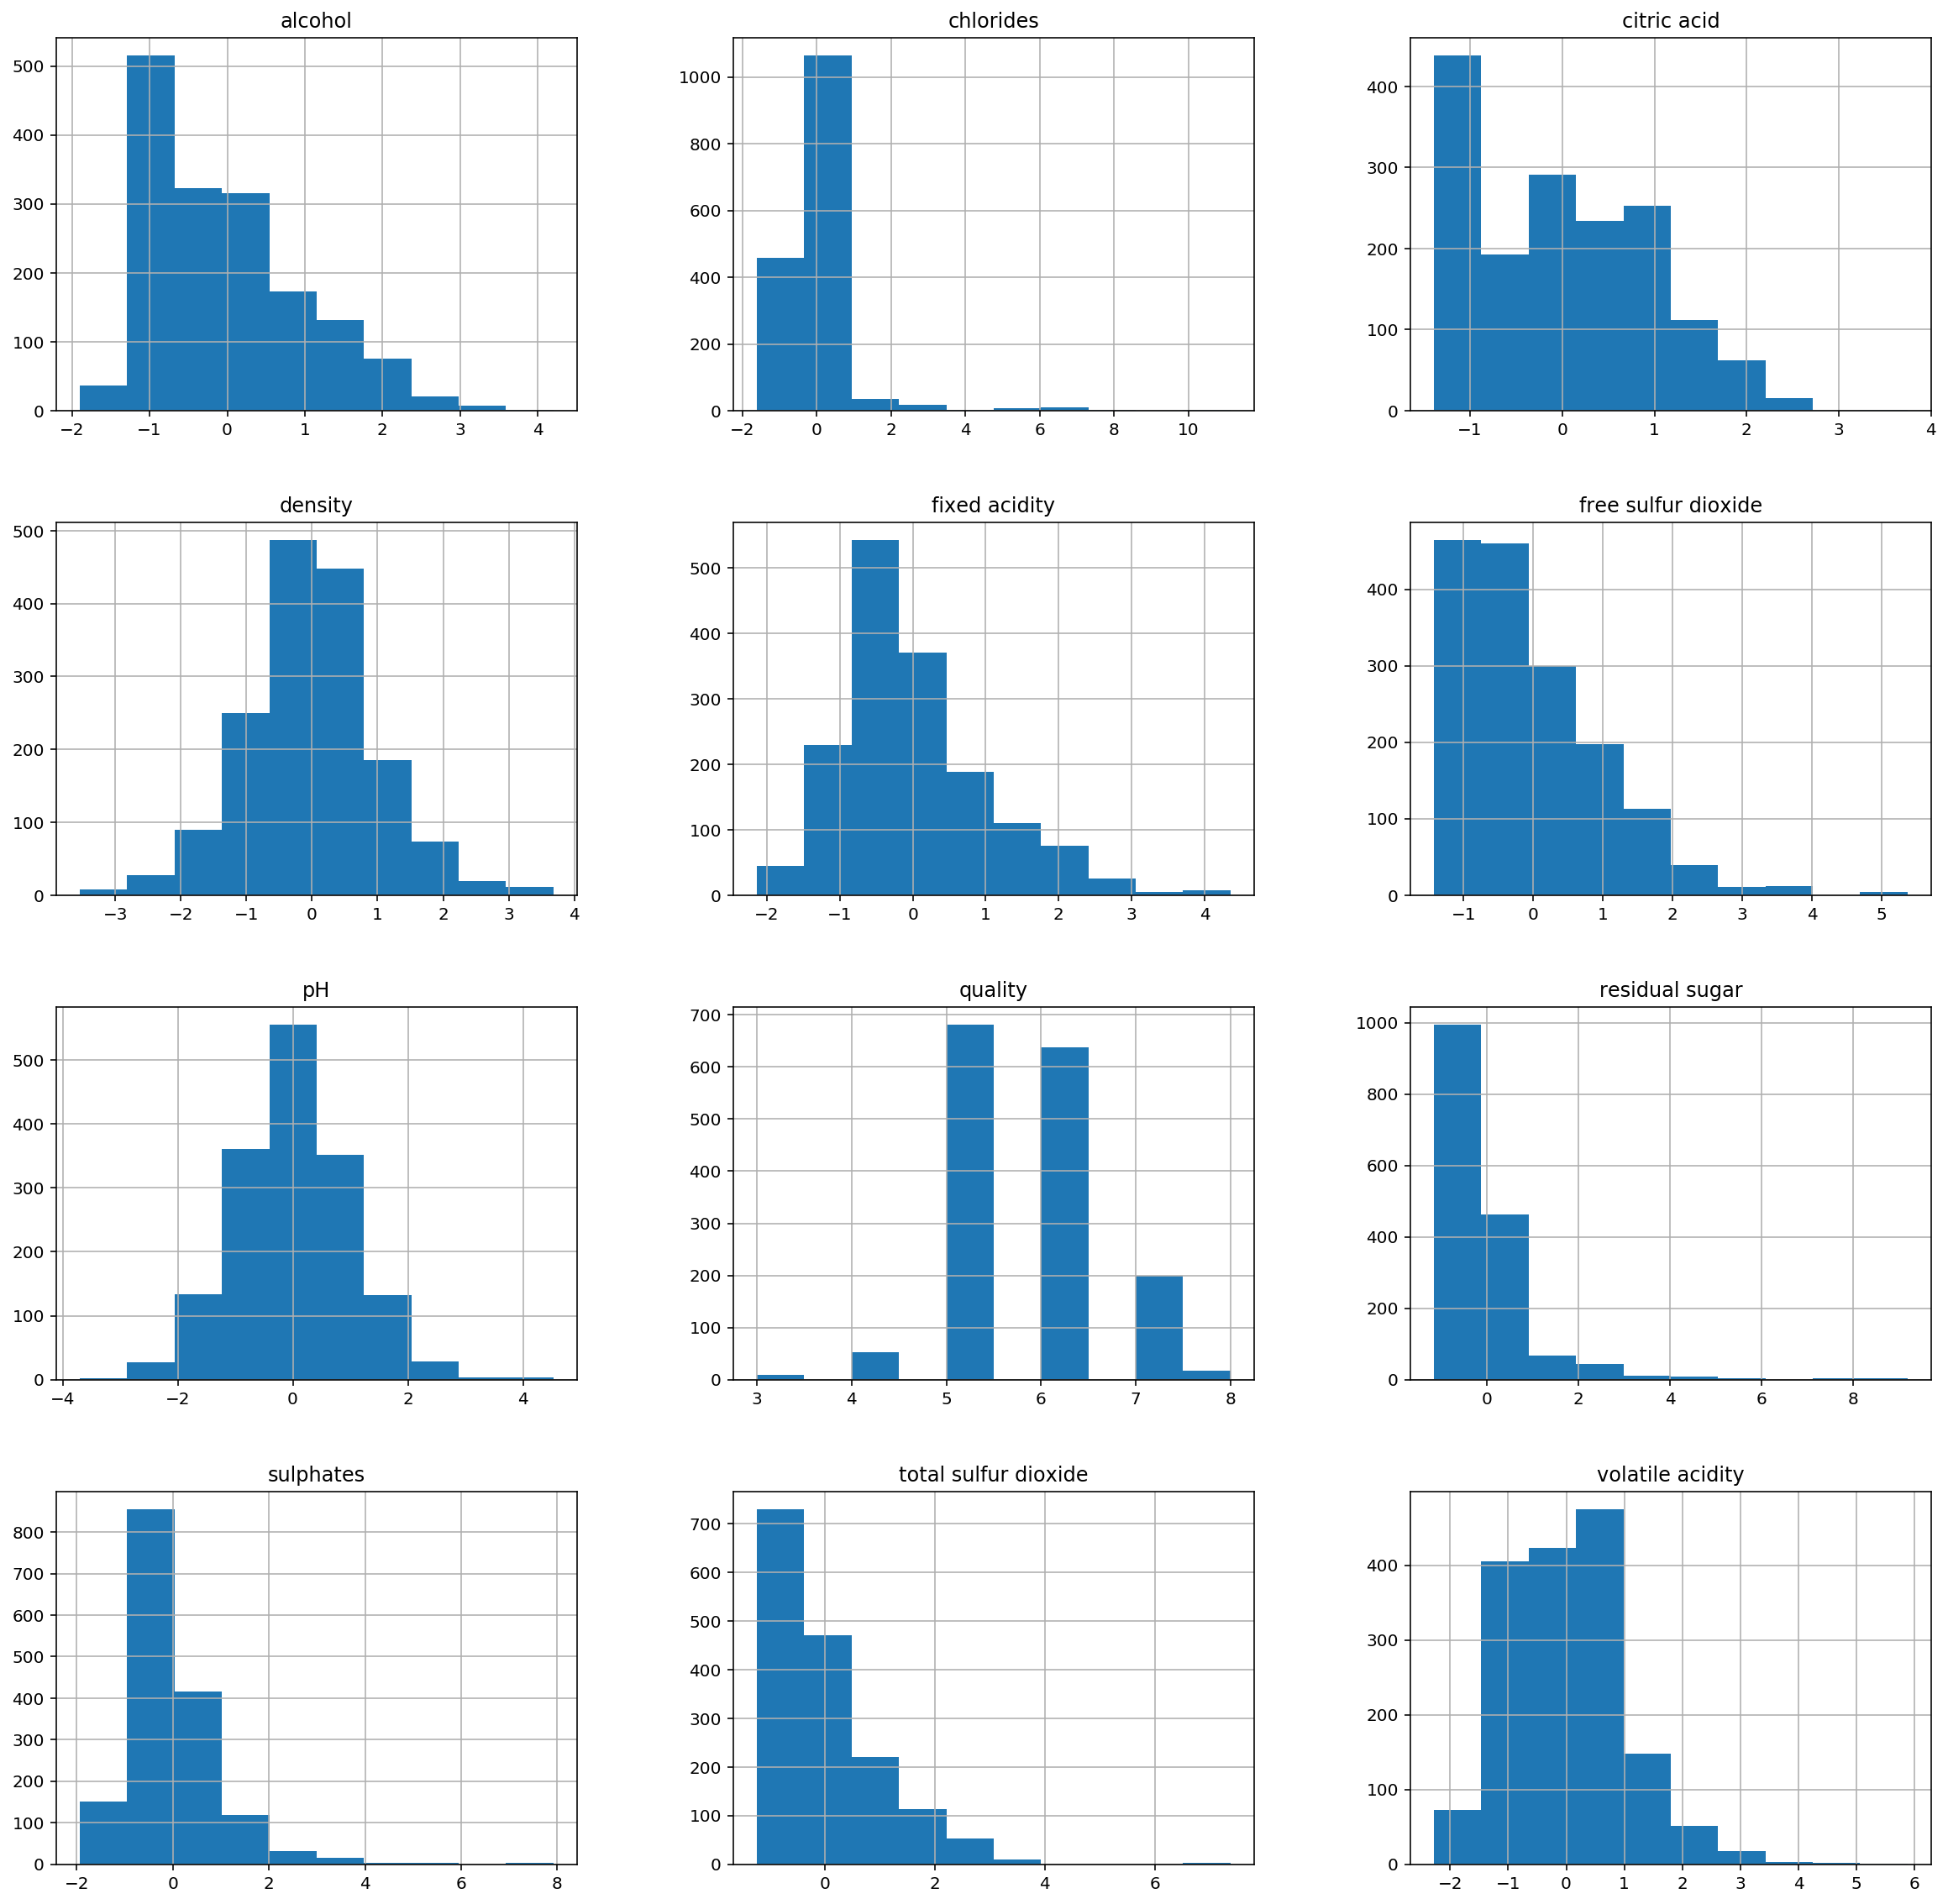

In [578]:
wineData.hist(figsize = (20, 20))
plt.show()

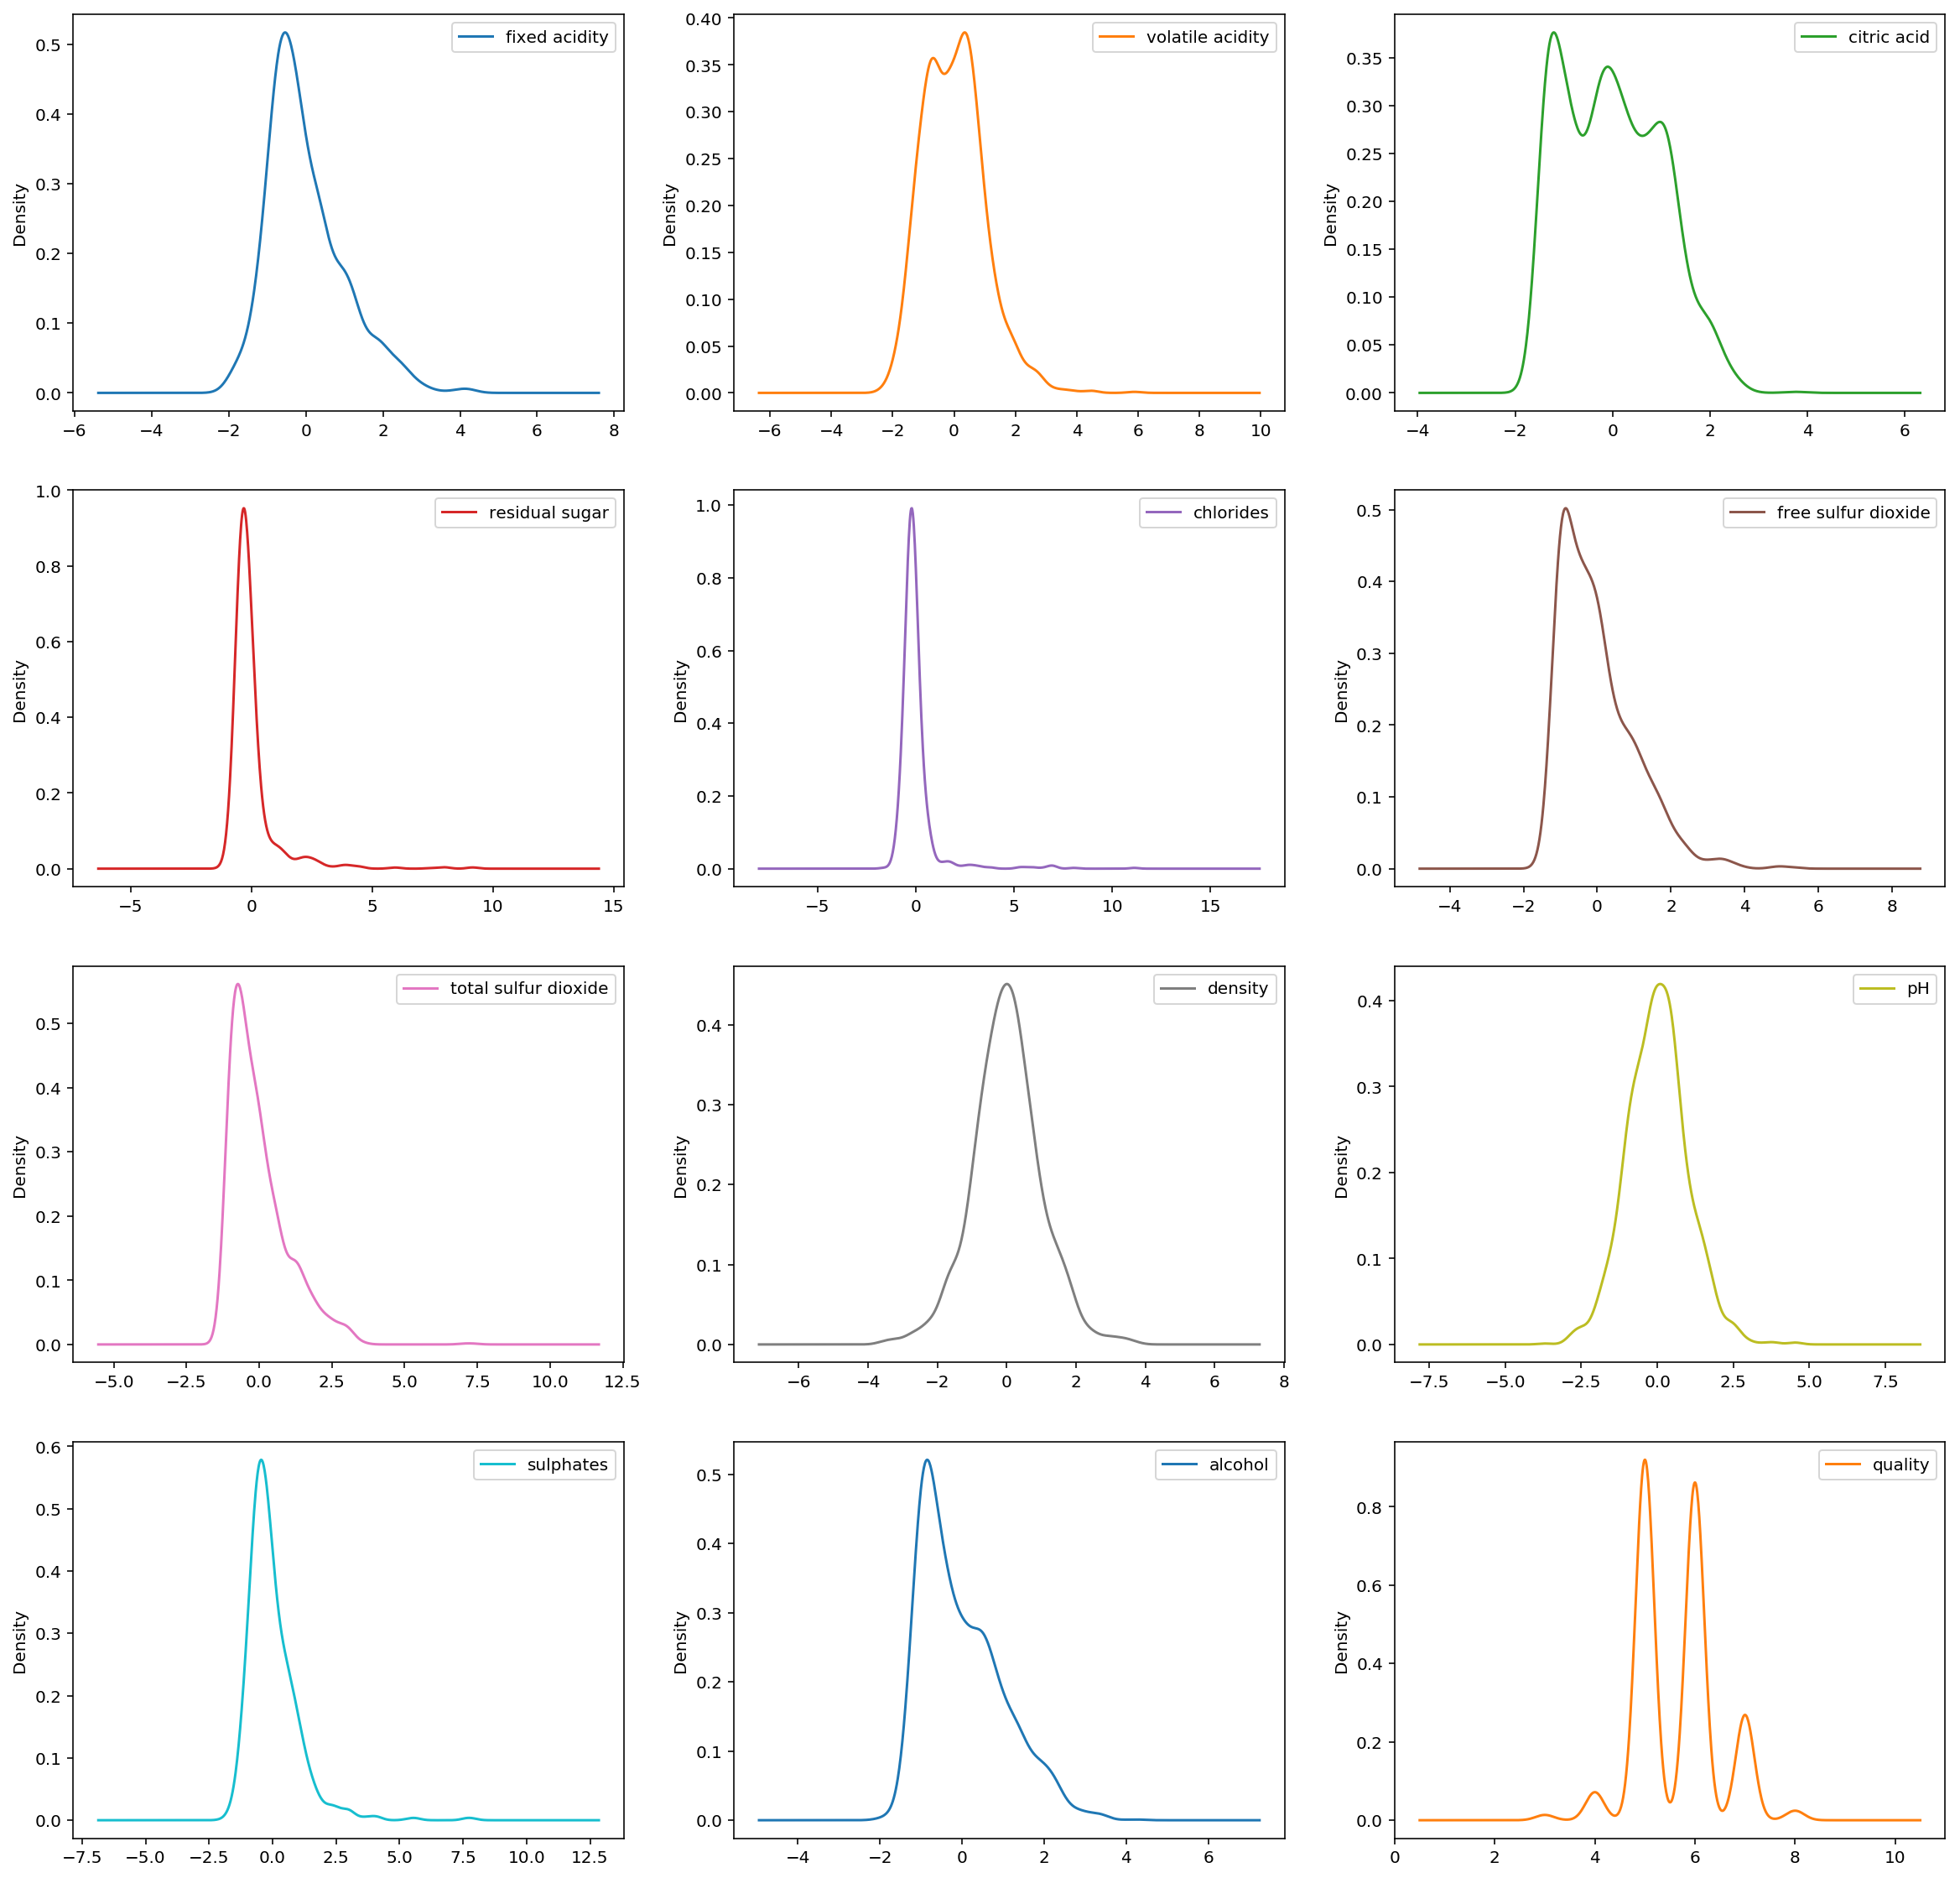

In [579]:
wineData.plot(kind='density', subplots=True, layout=(4,3), sharex=False, figsize = (20, 20))
plt.show()

In [580]:
correlation = wineData.corr(method = "spearman")
correlation

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.278282,0.661708,0.220701,0.250904,-0.175137,-0.088417,0.623071,-0.706674,0.212654,-0.066576,0.114084
volatile acidity,-0.278282,1.000000,-0.610259,0.032386,0.158770,0.021163,0.094110,0.025014,0.233572,-0.325584,-0.224932,-0.380647
citric acid,0.661708,-0.610259,1.000000,0.176417,0.112577,-0.076452,0.009400,0.352285,-0.548026,0.331074,0.096456,0.213481
residual sugar,0.220701,0.032386,0.176417,1.000000,0.212959,0.074618,0.145375,0.422266,-0.089971,0.038332,0.116548,0.032048
chlorides,0.250904,0.158770,0.112577,0.212959,1.000000,0.000805,0.130033,0.411390,-0.234361,0.020825,-0.284504,-0.189922
free sulfur dioxide,-0.175137,0.021163,-0.076452,0.074618,0.000805,1.000000,0.789698,-0.041178,0.115679,0.045862,-0.081367,-0.056901
total sulfur dioxide,-0.088417,0.094110,0.009400,0.145375,0.130033,0.789698,1.000000,0.129332,-0.009841,-0.000504,-0.257806,-0.196735
density,0.623071,0.025014,0.352285,0.422266,0.411390,-0.041178,0.129332,1.000000,-0.312055,0.161478,-0.462445,-0.177074
pH,-0.706674,0.233572,-0.548026,-0.089971,-0.234361,0.115679,-0.009841,-0.312055,1.000000,-0.080306,0.179932,-0.043672
sulphates,0.212654,-0.325584,0.331074,0.038332,0.020825,0.045862,-0.000504,0.161478,-0.080306,1.000000,0.207330,0.377060


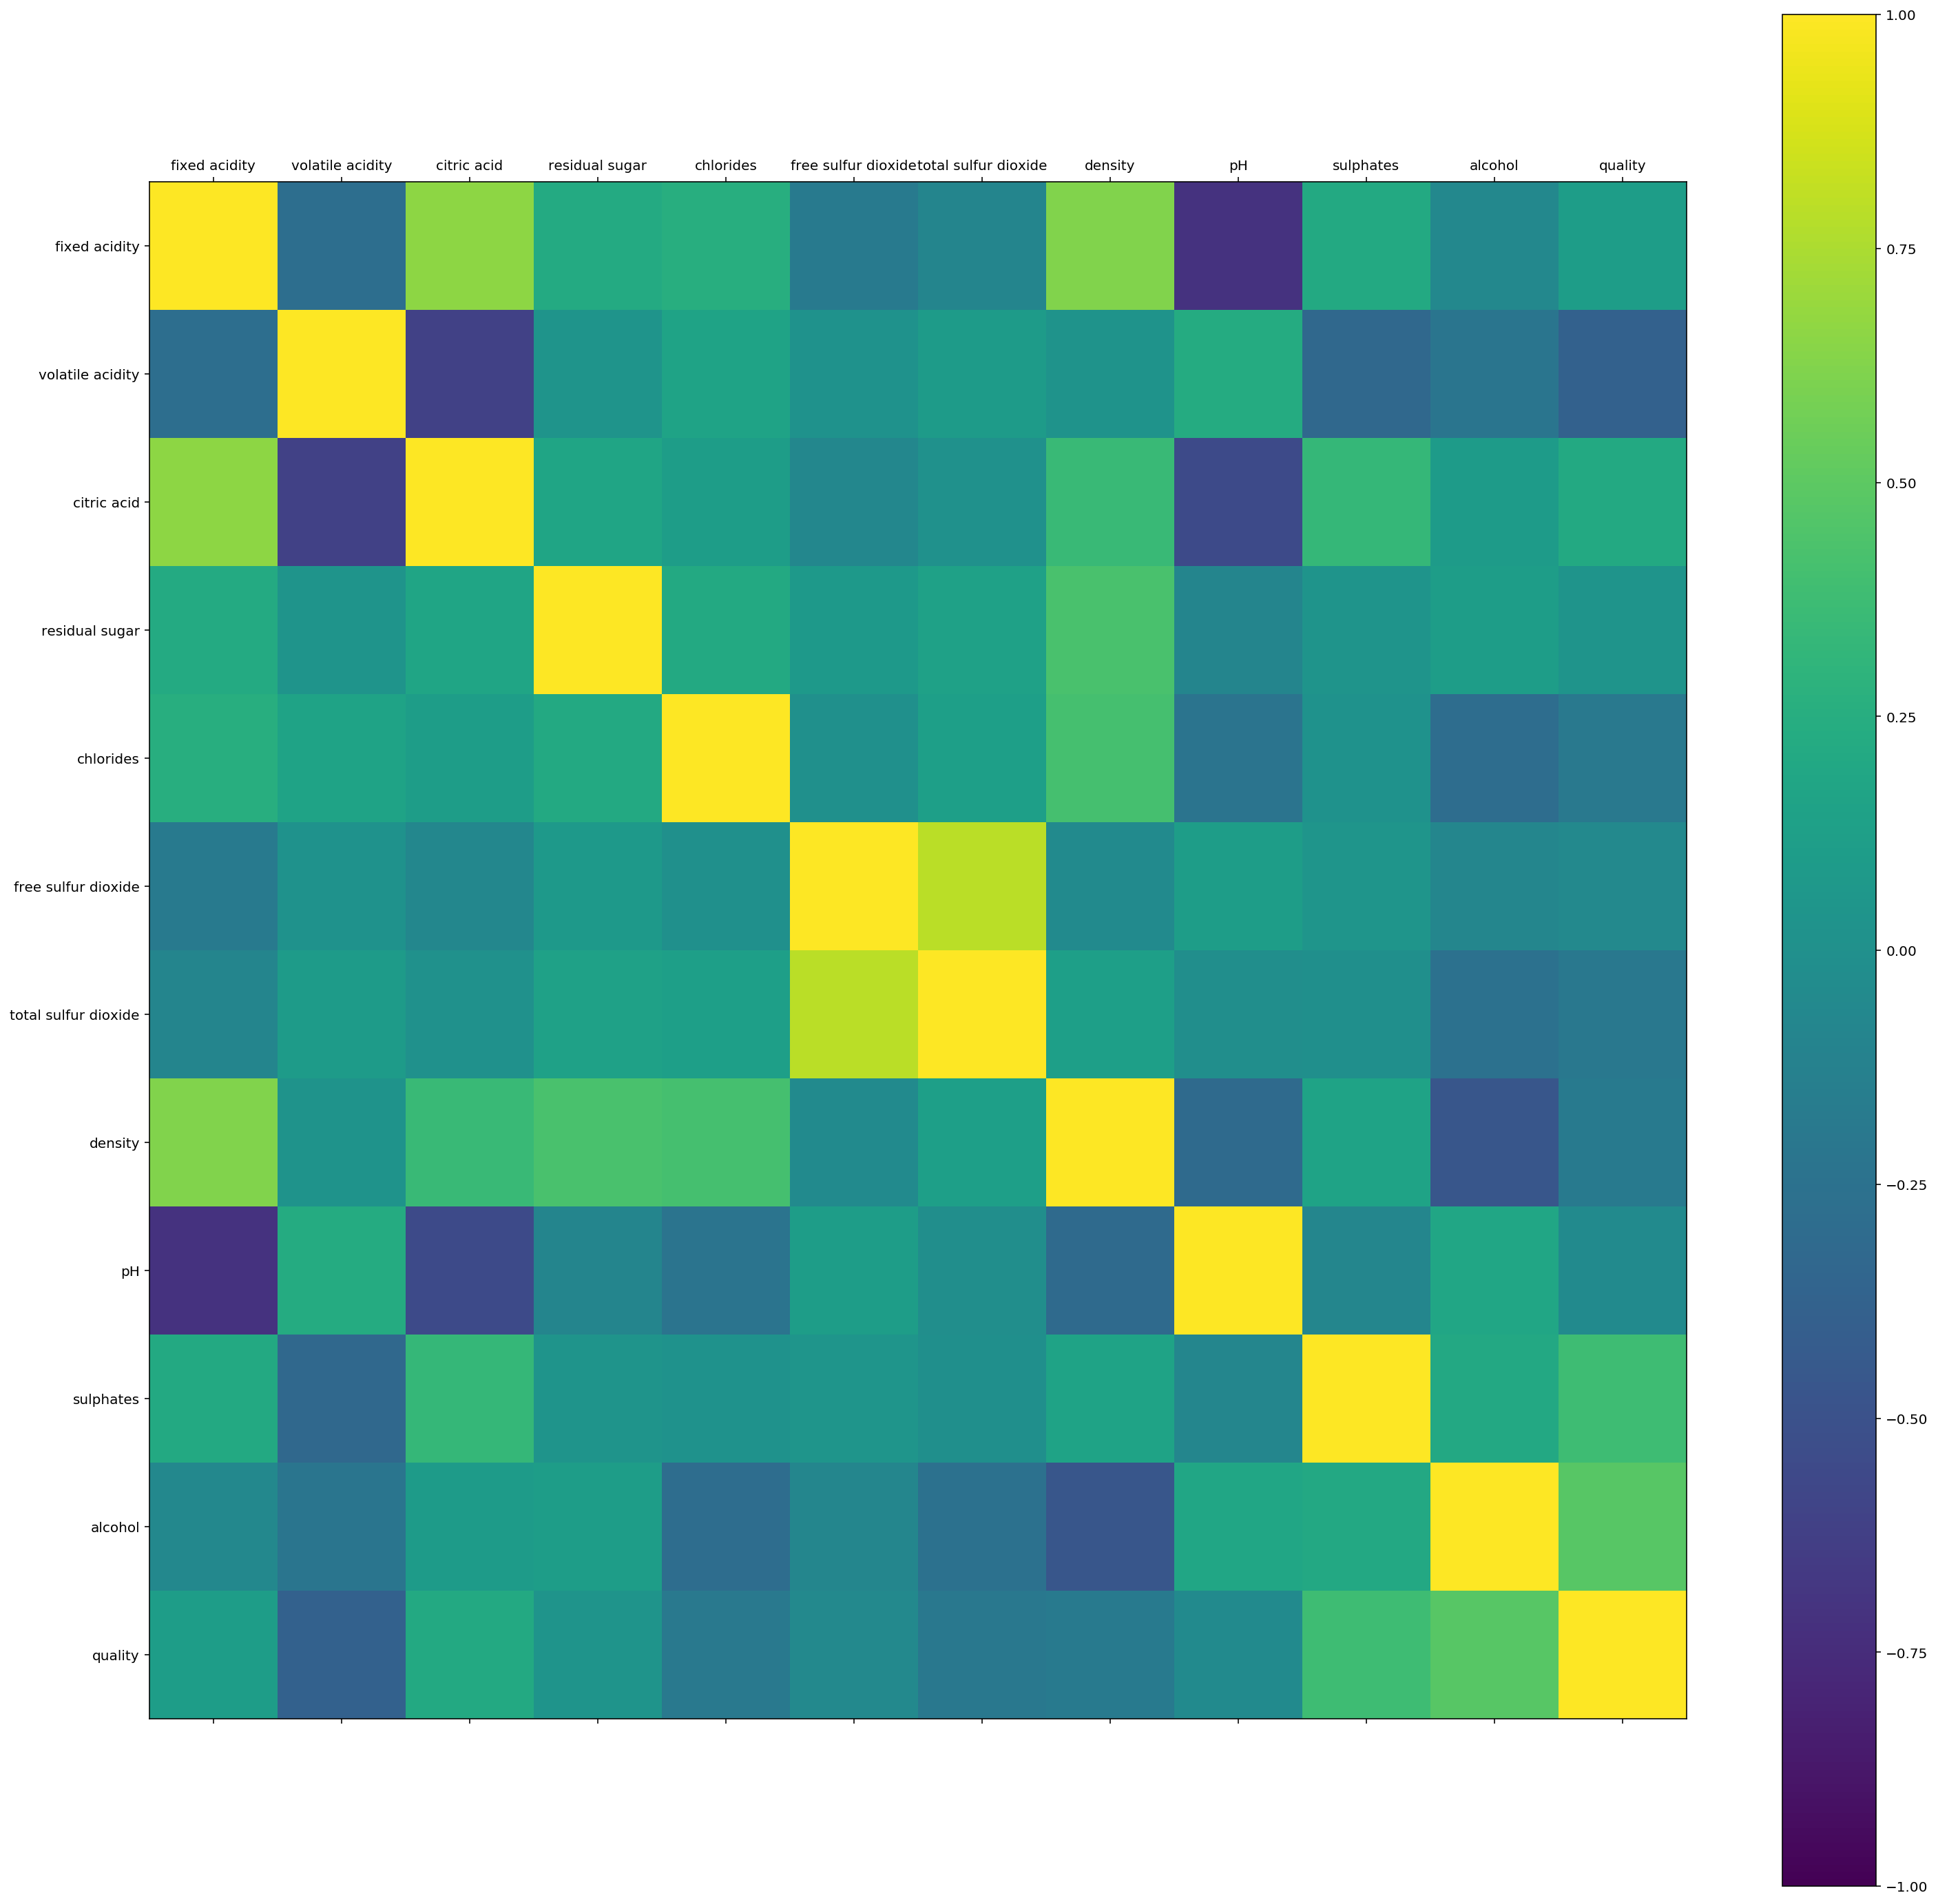

In [581]:
labels = list(wineData)
fig, ax = plt.subplots(1, 1, figsize=(25, 25))
ax.matshow(correlation)

ticks = range(0, len(labels))
cax = ax.matshow(correlation, vmin=-1, vmax=1)
fig.colorbar(cax)

ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()

There is a very high corelation between total sulfur dioxide and free sulfur dioxide. One of these features can be dropped. Correlation of free sulfur dioxide is very less with quality as compared to total sulfur dioxide. So we will drop free sulfur dioxide. 

In [582]:
selectedFeatures = list(wineData)
selectedFeatures.remove("quality")
selectedFeatures.remove('free sulfur dioxide')

### Split dataset

In [583]:
trainSet, testSet = splitDataSet(wineData, 0.7)

xTrain = trainSet.as_matrix(columns = selectedFeatures)
xTest = testSet.as_matrix(columns = selectedFeatures)

yTrain = trainSet["quality"].as_matrix()
yTest = testSet["quality"].as_matrix()

print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)

(1119, 10)
(480, 10)
(1119,)
(480,)


### Train model

In [584]:
classifier = KNearestClassifier(xTrain, yTrain, DistanceMeasure.EuclidianDistance)

### Predict the values

In [585]:
yPrediction = []
k = 20

for x in xTest:
    yPrediction.append(classifier.predict(x, k))

### Calculate misclassification rate

In [586]:
print ("Misclassification is " + str(misclassificationRate(yTest, yPrediction)))

Misclassification is 0.427083333333


## KNN for regression

### Train model

In [587]:
regressor = KNearestRegressor(xTrain, yTrain, DistanceMeasure.EuclidianDistance)

### Predict the values

In [588]:
yPrediction = []
k = 20

for x in xTest:
    yPrediction.append(regressor.predict(x, k))

### RMSE

In [589]:
print ("RMSE is " + str(RMSE(yTest, yPrediction)))

RMSE is 0.030194321463


# Optimizing the value of K for classification
Selecting optimal value of K is very important for KNN. If a very small value of K is selected then noise in data set will have very high impact on KNN algorithm. Very big values will be computationally expensive. Hence the value should be large enough that the noise has little effect and small enough to make calculation easy.<br>Many times the value K is selected as <br>sqrt(N), where N is the size of training set.<br>Here we will perform grid search to find the optimal value of K.

In [590]:
trainSet, testSet = splitDataSet(wineData, 0.7)

xTrain = trainSet.as_matrix(columns = selectedFeatures)
xTest = testSet.as_matrix(columns = selectedFeatures)

yTrain = trainSet["quality"].as_matrix()
yTest = testSet["quality"].as_matrix()

print(xTrain.shape)
print(xTest.shape)
print(yTrain.shape)
print(yTest.shape)

(1119, 10)
(480, 10)
(1119,)
(480,)


In [598]:
kGrid = range(2, 15)

avgLoss = None
optimalK = None

lossList = []
for k in kGrid:
    loss = kFoldAnalysis(xTrain, yTrain, KNearestClassifier, 
              {"distanceMeasure":DistanceMeasure.EuclidianDistance}, 4, misclassificationRate, {"k":k})
    lossList.append(np.average(loss))
    
    if avgLoss == None or avgLoss > lossList[-1]:
        avgLoss = lossList[-1]
        optimalK = k


In [599]:
print("Optimal value of K is "+ str(optimalK))

Optimal value of K is 6


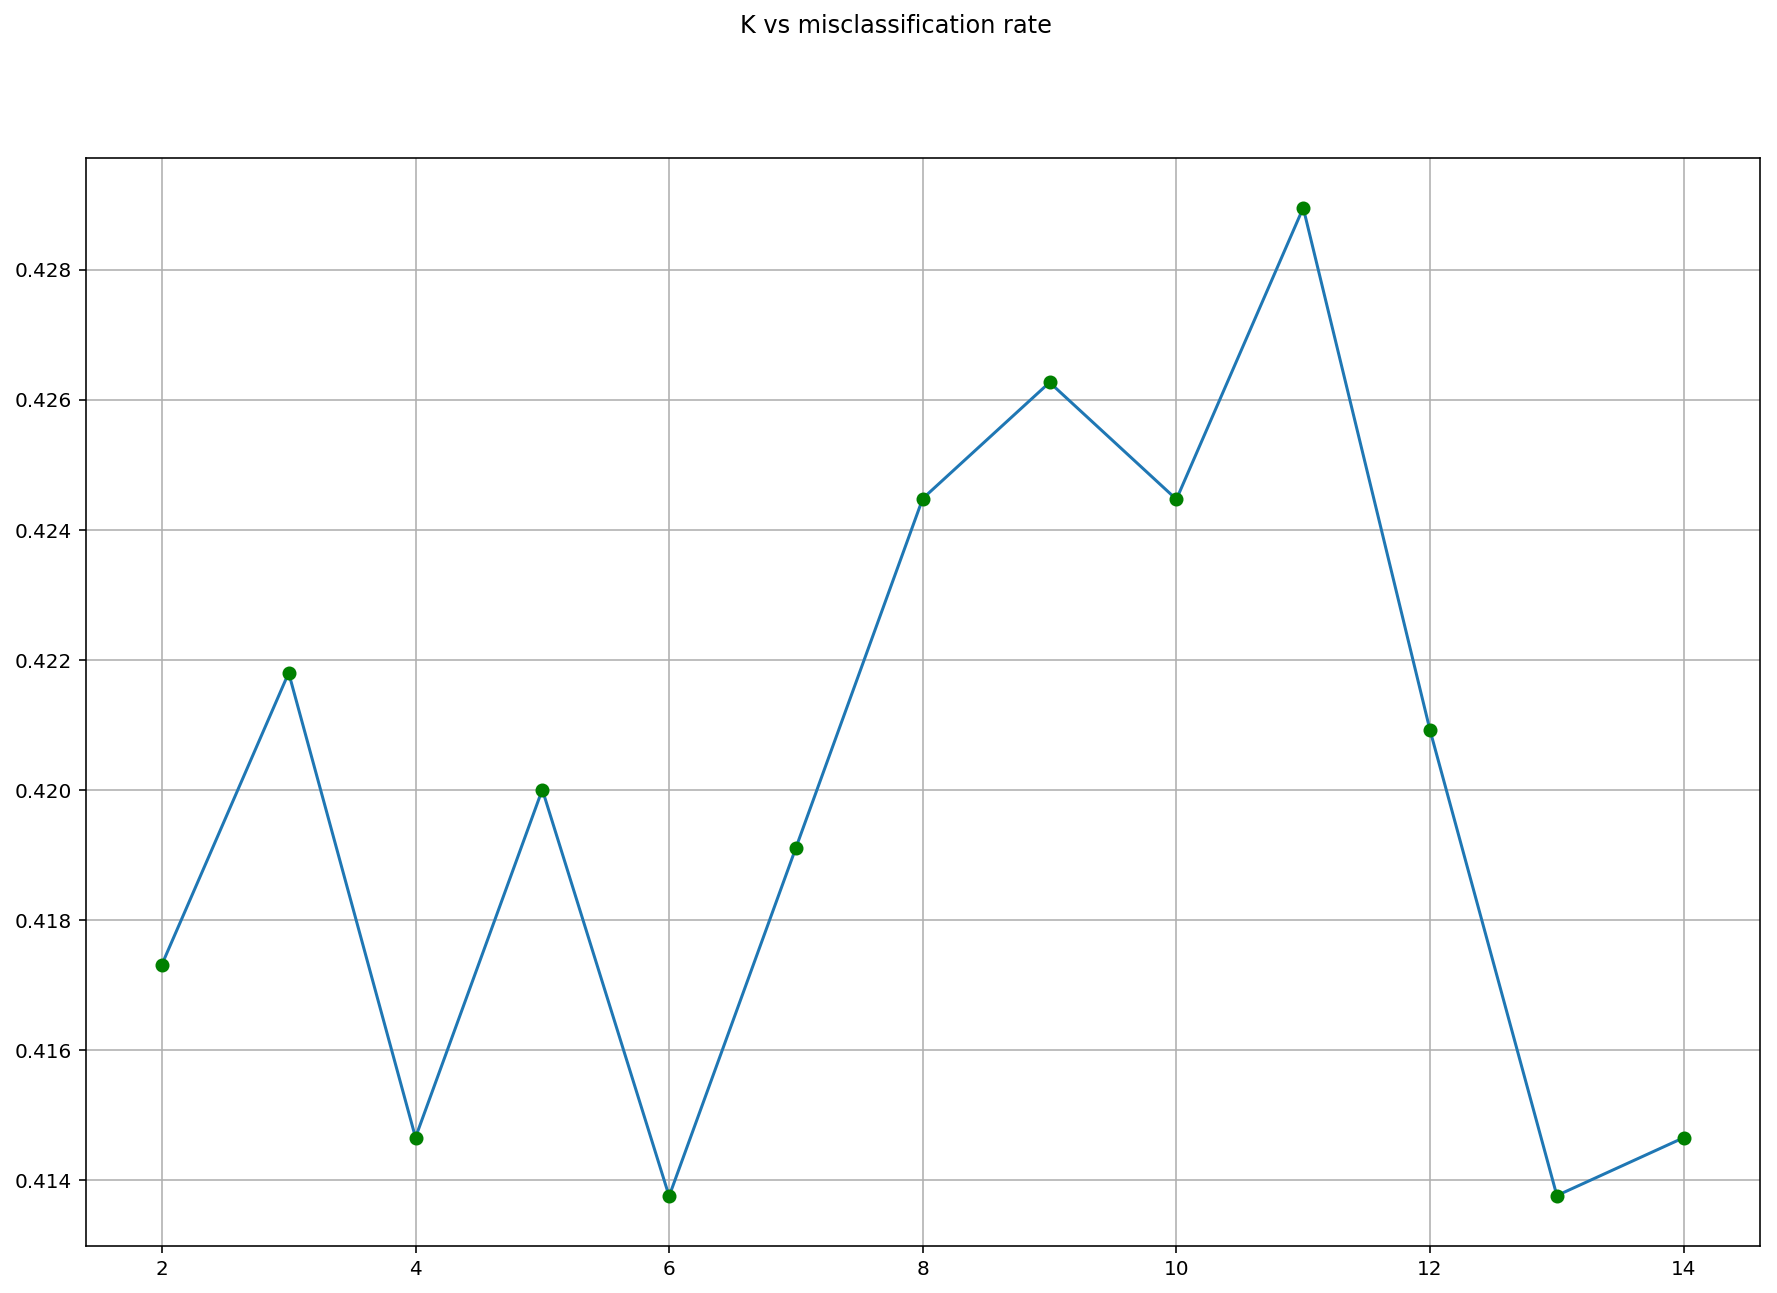

In [605]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

plt.suptitle("K vs misclassification rate")
ax.plot(kGrid, lossList)
ax.plot(kGrid, lossList, "go")
ax.grid()
#ax.xticks(kGrid)

plt.show()

In [603]:
"""Retrain model"""
classifier = KNearestClassifier(xTrain, yTrain, DistanceMeasure.EuclidianDistance)

yPrediction = []

for x in xTest:
    yPrediction.append(classifier.predict(x, optimalK))

print ("Misclassification is " + str(misclassificationRate(yTest, yPrediction)))

Misclassification is 0.44375


### Optimizing the value of K for regression

In [606]:
kGrid = range(2, 15)

avgLoss = None
optimalK = None

lossList = []
for k in kGrid:
    loss = kFoldAnalysis(xTrain, yTrain, KNearestRegressor, 
              {"distanceMeasure":DistanceMeasure.EuclidianDistance}, 4, RMSE, {"k":k})
    lossList.append(np.average(loss))
    
    if avgLoss == None or avgLoss > lossList[-1]:
        avgLoss = lossList[-1]
        optimalK = k


In [607]:
print("Optimal value of K is "+ str(optimalK))

Optimal value of K is 9


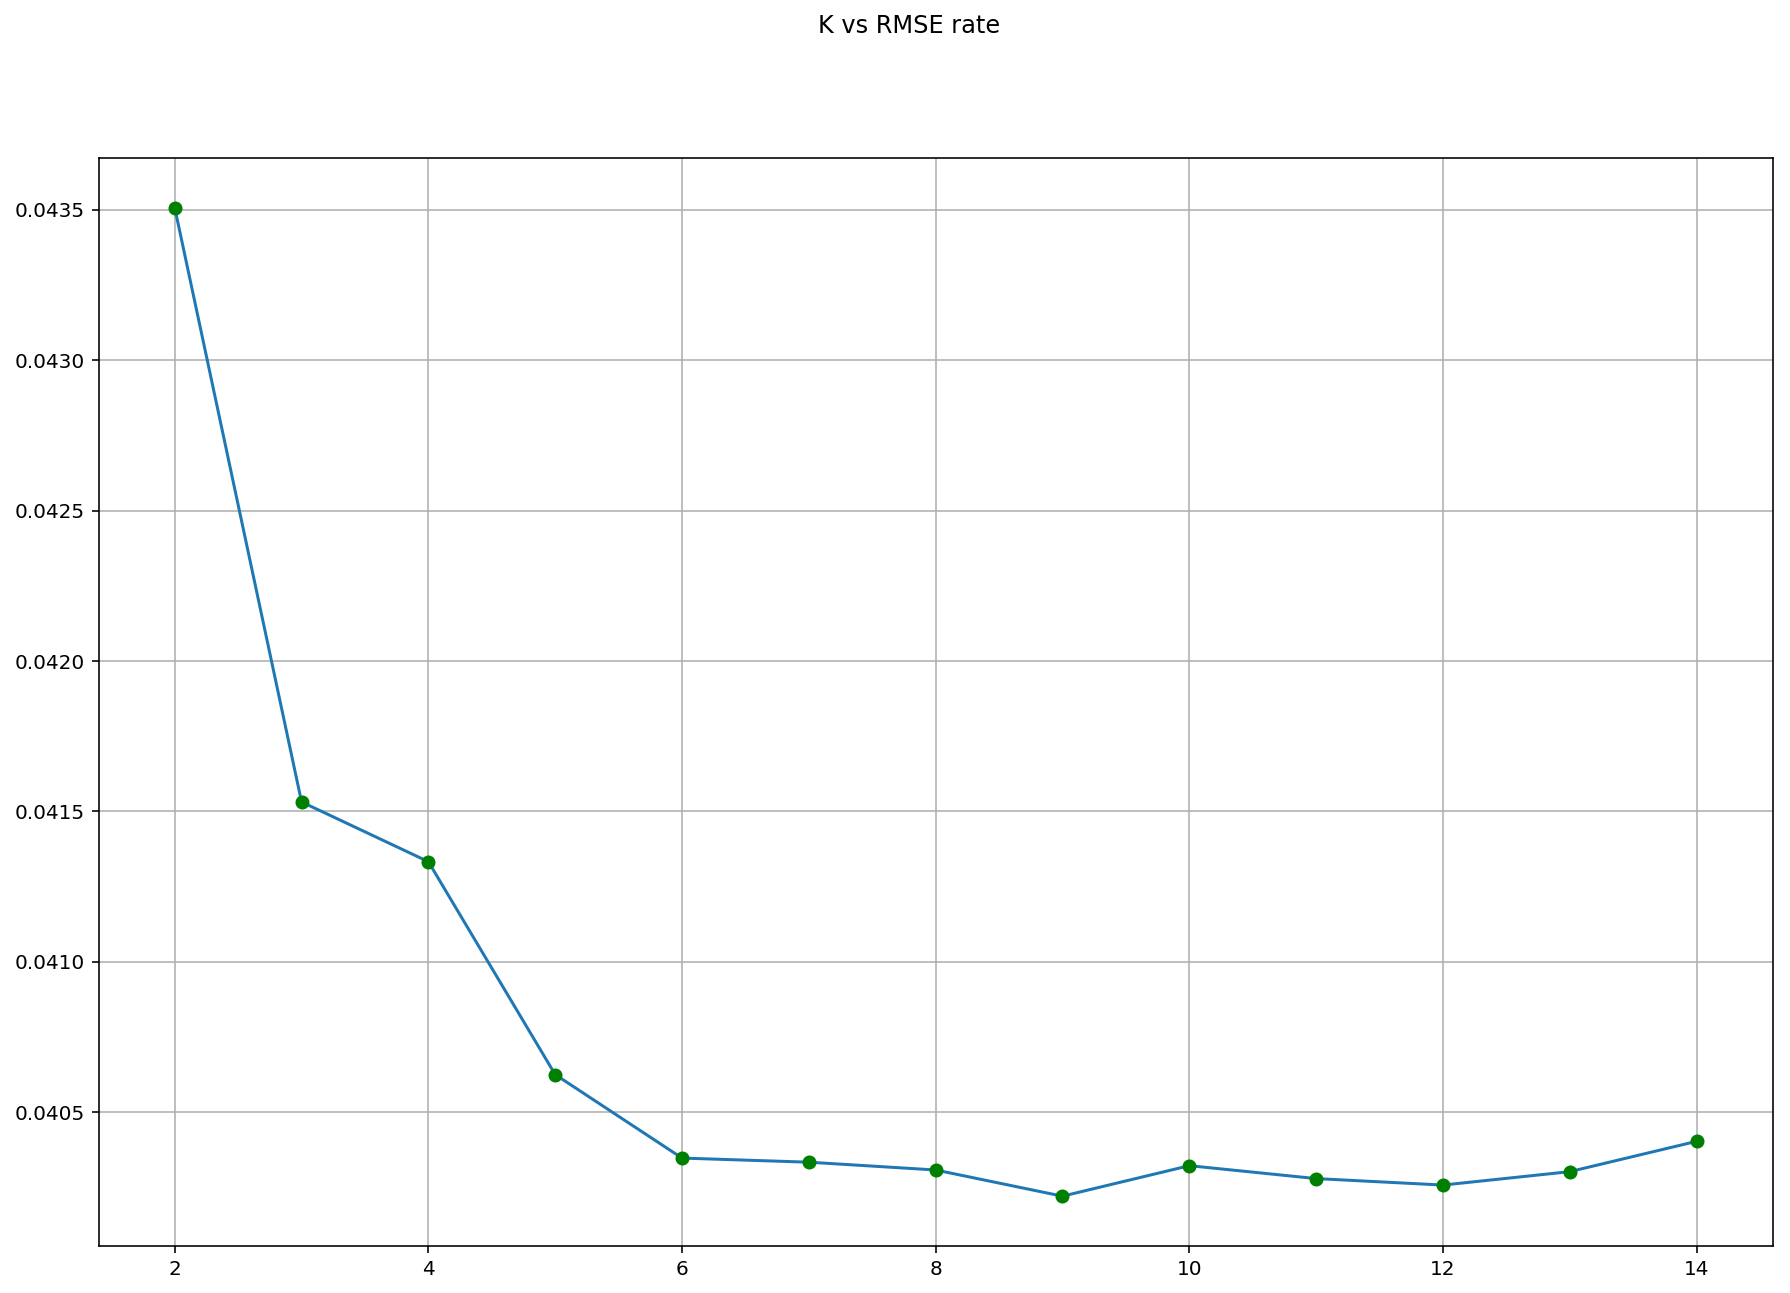

In [608]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

plt.suptitle("K vs RMSE rate")
ax.plot(kGrid, lossList)
ax.plot(kGrid, lossList, "go")
ax.grid()
#ax.xticks(kGrid)

plt.show()

In [609]:
"""Retrain model"""
classifier = KNearestRegressor(xTrain, yTrain, DistanceMeasure.EuclidianDistance)

yPrediction = []

for x in xTest:
    yPrediction.append(classifier.predict(x, optimalK))

print ("Misclassification is " + str(RMSE(yTest, yPrediction)))

Misclassification is 0.0309129630184
